# Map PDF protocol demo

This demo is intended to show the capability and general workflow of the mapPDF protocol as described in [insert link to paper]. It is intended as a quick start soution for a novel python user who doesnt want to create a similar solution from scratch.

#### Overall workflow:

1. Set up the paths to metadata and images / data files.
2. Create a collection dataframe including that information.
3. Transform data to PDF
4. Use pearsonr to screen the dataset.
5. Apply a fit recipe and save refined parameters
6. Visualize refined parameters.
7. Adjust/improve model

It was designed to work with output files from the XPD beamline at NSLSII.
Output from other instruments can be used given the general metadata format is the same, or if the user is willing to adjust the import script. Once set up, the protocol is intended to work with minimal adjustments between the experiments.

#### Requirements:
The only requiremenents are the packages in the imports cell and the 'mappdf_utils.py' which can be found alongside this notebook.

### Main imports for mapPDF
The demo utilizes a number of standard python packages as well as custom functions from 'mappdf_utils.py'

In [38]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from diffpy.pdfgetx import PDFGetter, PDFConfig

# utilities for mapPDF
from mappdf_utils import *

### Define filepath to informations
The following cells sets the paths to the text document with the metadata and points towards the location of the I(q) files. 

#### This is the only parameter that needs to change between datasets apart from the model

In [2]:
# defined example files
meta_data_file = 'meta/20161115-220716_grid_scan_md2.txt'
chi_files_dir = 'chi/'

Next, we define the parameters for PDF transformation

In [16]:
pdf_params = dict(qmaxinst=22, qmin=0.8, qmax=17, dataformat='Qnm',
                   rmin=0.0, rmax=100.0, rstep=0.01)

### Load raw I(Q) data
Then we define which columns from the metadata file we are interested in by defining a qoi_columns list. A single function then reads in the desired information together with the corresponding '.chi' files. We then store everything in our collection dataframe 'df'

In [18]:
qoi_colmns  = ['diff_x', 'diff_y', 'filename', 'composition']

df = mappdf_load_chi(meta_data_file, qoi_columns=qoi_colmns, root=chi_files_dir)

### Transform data to PDF
We create G(r) from each entry in the collection 'df' using the parameters defined above. We designate file nr. 15 as our background as well as point for comparison for raw I(q) and G(r) using Pearsonr test.

In [21]:
# process the data
bgr = 15
process_chi_df(df, pdf_params, 
               background=bgr, iq_pearson_data=bgr, gr_pearson_data=bgr);

-0.822670484458


/Users/Anton/Documents/PhD/Seafile/Columbia/diffpy.mappdf/demo/mappdf_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **pdf_parameters)[1]


We can check the contents of the collection at any point using the standard function in the next cell

In [4]:
# view the first 5 rows for example
#df.head()

### Collection screening using Pearson maps for I(Q)
We can check for similarity to our background file using standar matplotlib functionality

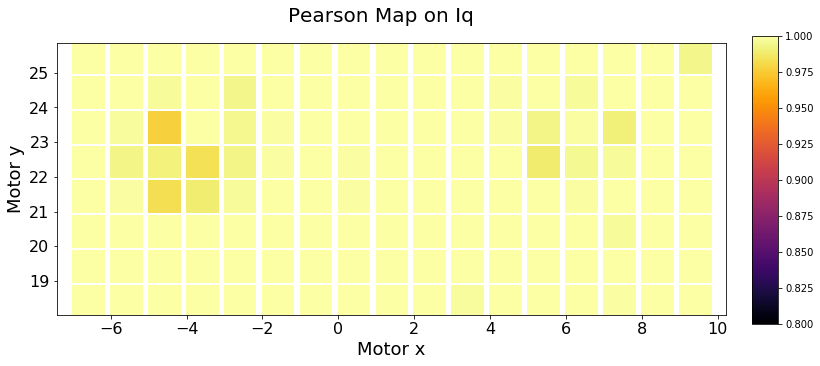

In [28]:
# Create new figure:
fig, ax = plt.subplots(1,1, figsize=(12, 5), sharey=True)


# Plot the data :
im = ax.scatter(df['diff_x'], df['diff_y'], c=df['iq_pearson'], vmin=.8, marker='s', s=1000)


## Set axis labels and style
fig.suptitle('Pearson Map on Iq', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
ax.set_ylabel('Motor y')
ax.set_xlabel('Motor x')
conf_label_size(ax, 18)
conf_tick_size(ax, 16)
plt.set_cmap('inferno')
fig.colorbar(im, cax=cax)

Unsurprisingly, all datasets are very similar, since the amount of material is very low and the background signal dominates the measurement.

### Pearson map of G(r)
We can however examine the background subtracted and transformed to PDF datasets, using the same functions as before. Now there is clear contranst between signal from support material and the nanomaterial.

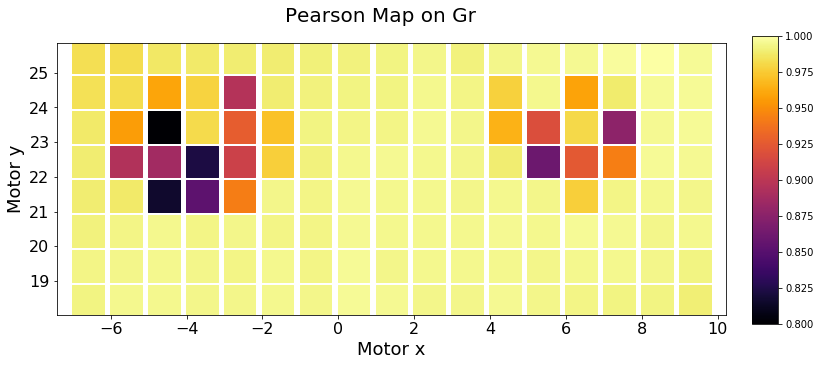

In [29]:
# create scatter plot with pearson map
# Create new figure:
fig, ax = plt.subplots(1,1, figsize=(12, 5), sharey=True)


# Plot data:
im = ax.scatter(df['diff_x'], df['diff_y'], c=df['gr_pearson'], vmin=.8, marker='s', s=1000)


## Set axis labels and figure style:
fig.suptitle('Pearson Map on Gr', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
ax.set_ylabel('Motor y')
ax.set_xlabel('Motor x')
conf_label_size(ax, 18)
conf_tick_size(ax, 16)
plt.set_cmap('inferno')
fig.colorbar(im, cax=cax)

# PDF refinements
Now that we have everything in one collection dataframe, it is easy to apply a fit recipe to each entry and append the results. The exact fit recipe will vary from one experiment to the other. The general approach however is similar to the initial steps of building the dataframe.


### Load refinements from disk
In order to save time for the demonstration purposes, the results from structural refinements have been saved to a file and can be loaded here.

In [30]:
rf = pd.read_csv('refined_params.csv')
print(list(rf.keys()))

['file_index', 'adp_1', 'adp_2', 'delta2', 'lattice constant', 'rw', 'scale', 'psize']


In [31]:
d = pd.concat([df, rf], axis=1, join='inner')

## Make a heatmap of rw values using python and matplotlib functionality

We can now visualize the refined parameters for the dataset.

Here is an example of the heatmap plot using simple interation over the collection

In [32]:
#d.head(1)

In [28]:
rf.head()
rf.to_csv('refined_params_2.csv')

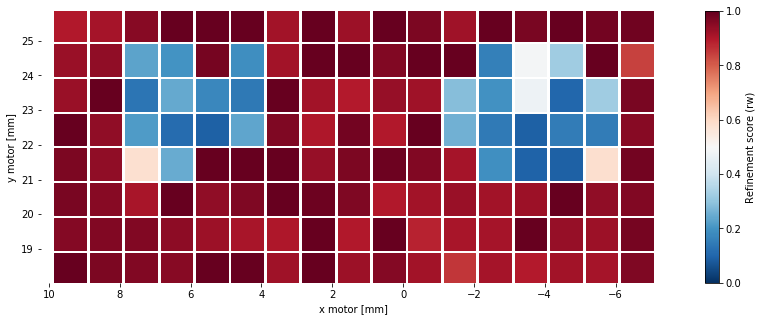

In [33]:
## define the size of the figure plot
plt.figure(figsize=(14,5))


## perform the iteration
plt.scatter(d['diff_x'], d['diff_y'], c=d['rw'], cmap='RdBu_r', vmin=0, vmax=1, marker='s', s=1000)

    
# add the colorbar
plot = plt.colorbar()

# Set labels
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')
plot.set_label('Refinement score (rw)')
    
# remove the box around the graph
plt.gca().invert_xaxis()
for spine in plt.gca().spines.values():
    spine.set_visible(False)

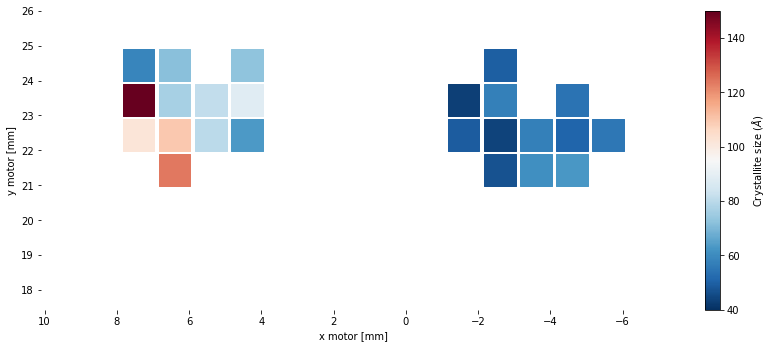

In [34]:
## define the size of the figure plot
plt.figure(figsize=(14,5.5))

## perform the iteration
where = d['rw']<0.3
plt.scatter(d['diff_x'][where], d['diff_y'][where], c=d['psize'][where], cmap = 'RdBu_r', vmin = 40, vmax = 150, marker = 's',s=1000)

    
# add the colorbar
plot = plt.colorbar()

#keep the limits as before
plt.xlim(-7.2,10.1)
plt.ylim(17.43,26)

# Set labels
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')
plot.set_label('Crystallite size ($\AA$)')
    
# remove the box around the graph
plt.gca().invert_xaxis()
for spine in plt.gca().spines.values():
    spine.set_visible(False)

## Example of multiple filtering:

It is easy to define multiple criteria for filtering as well as making multiple 1D slices of the collection. Here we visualize the diffraction patterns for two arbitrary sets of refinements that we define ourselves. First we filter out all the diffraction patterns with better structural refinement results, with rw < 60%. Then, we isolate the rest, i.e. 60% < rw < 100% 


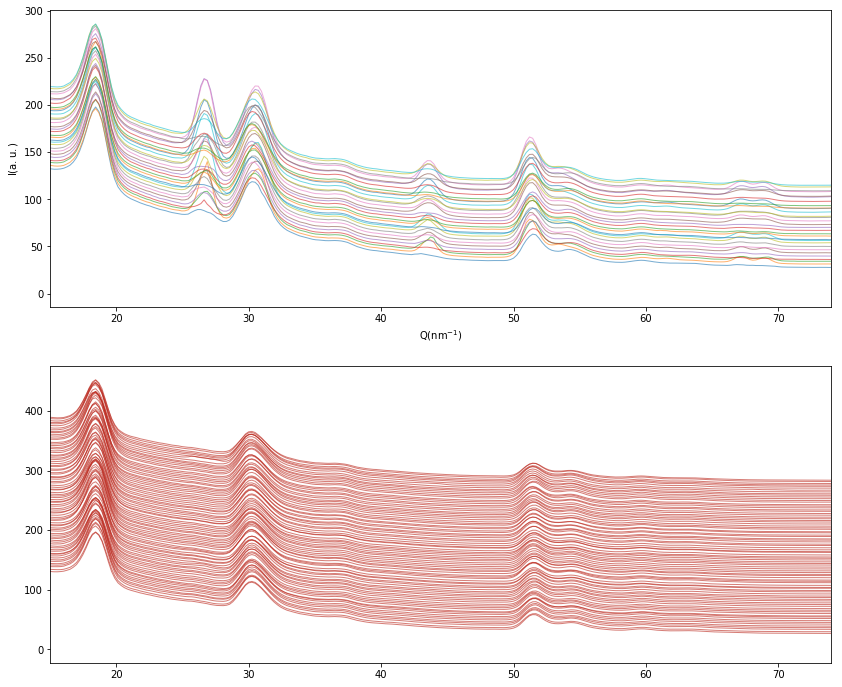

In [35]:
# make a figure
fig, ((ax1,ax2)) = plt.subplots(2, 1, figsize=[14,12])
offset_plot1=0
offset_plot2=0


## perform iteration and filtering by a criteria
x = d['q']
y = d['iq']
rw = d['rw']

for i in range(len(d)):
    if np.all(rw[i] < 0.6):
        ax1.plot(x[i], y[i] + offset_plot1, lw=1,alpha=0.6)
        offset_plot1=offset_plot1+3
        
    elif np.all(rw[i] < 1):
        ax2.plot(x[i], y[i] + offset_plot2, lw=1,alpha=0.6,color='#bb271c')
        offset_plot2=offset_plot2+3
        
# set limits to focus on the part of the diffration part
ax1.set_xlim(15,74)
ax2.set_xlim(15,74)
# set labels for x and y axes
ax1.set_ylabel('I($\mathrm{a.u.}$)');
ax1.set_xlabel('Q($\mathrm{nm^{-1}}$)');

In [36]:
d.iloc[[0]]

,diff_x,diff_y,filename,composition,q,iq,iq_pearson,corrected_iq,gr,gr_pearson,file_index,adp_1,adp_2,delta2,lattice constant,rw,scale,psize
0,9.4,25.44,Catalyst_Array_DenseMap_075785_0001.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.7301698, 5.7302208...",0.994051,"[-15.0, -15.0, -15.0, -15.0, -15.0, -9.2698302...","[0.0, 0.00267066384714, 0.0052951427534, 0.007...",0.99653,0,0.00001,0.000008,27.627181,4.261763,0.899584,0.015228,34.331036


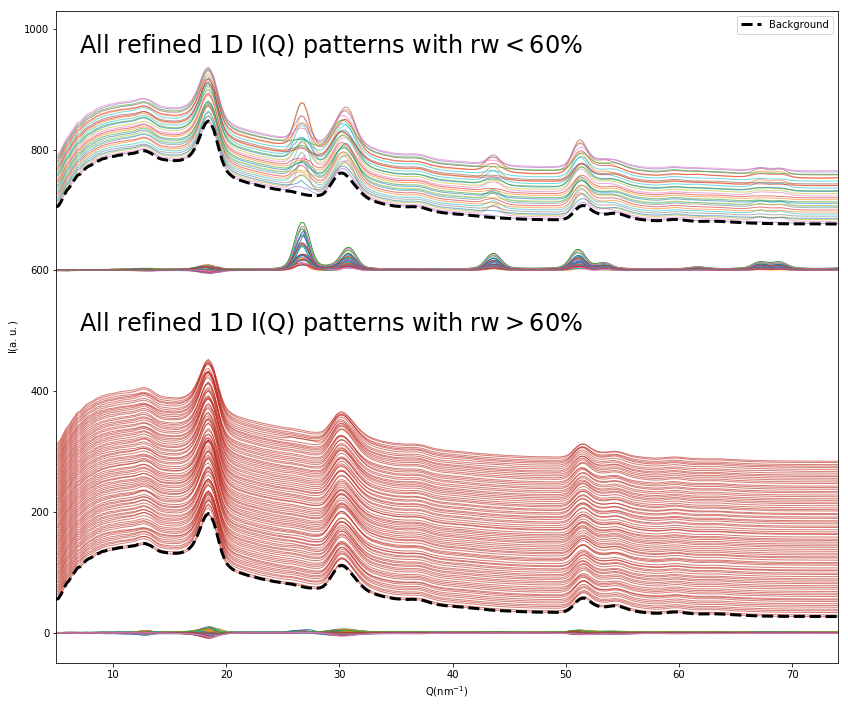

In [37]:
## Load a reference file for comparison
q, Iq = np.genfromtxt('./background/PCA_background.txt', skip_header=4).T        
ax1.plot(q,Iq,lw=3,ls='--',label = 'Background',color='black')
ax1.plot(q,Iq+650,lw=3,ls='--',color='black')

#define a figure
fig, ((ax1)) = plt.subplots(1, 1, figsize=[14,12])
offset_plot1=0
offset_plot2=0

x = d['q']
y = d['iq']
rw = d['rw']
for i in range(len(d)):
    if np.all(rw[i] < 0.6):
        ax1.plot(x[i], y[i] + 650 + offset_plot1, lw=1,alpha=0.6)
        ax1.plot(x[i], y[i]-np.interp(x[i],q,Iq)+600, lw=1)
        offset_plot1=offset_plot1+3
        
    elif np.all(rw[i] < 1):
        ax1.plot(x[i], y[i] + offset_plot2, lw=1,alpha=0.6,color='#bb271c')
        ax1.plot(x[i], y[i]-np.interp(x[i],q,Iq),lw=1)
        offset_plot2=offset_plot2+3

ax1.plot(q,Iq,lw=3,ls='--',label = 'Background',color='black')
ax1.plot(q,Iq+650,lw=3,ls='--',color='black')
# set style and labels
ax1.set_xlim(5,74)
ax1.set_ylim(-50,1030)
plt.legend()
ax1.set_ylabel('I($\mathrm{a.u.}$)') 
ax1.set_xlabel('Q($\mathrm{nm^{-1}}$)')
ax1.text(7, 500, 'All refined 1D I(Q) patterns with $\mathrm{rw>60\%}$', fontsize=24);
ax1.text(7, 960, 'All refined 1D I(Q) patterns with $\mathrm{rw<60\%}$', fontsize=24);